### Define major functions

#### Import packages and define functions

In [1]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date: 10/8/2021

import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy.special import factorial
import seaborn as sns
import pandas as pd
import re
import statistics
from scipy import stats
import math

# !{sys.executable} -m pip install mpl-axes-aligner
import mpl_axes_aligner

##############################

# define function charge() that calculates the net charge of an amino acid sequence
def charge(AAseq):
    netCharge = 0
    for aa in AAseq:
        if (aa == 'K') or (aa == 'R'):
            netCharge += 1
        elif (aa == 'D') or (aa == 'E'):
            netCharge -= 1
    return netCharge

##############################

# annotate viral family, Baltimore classification, and virus genome based on new information
famDict = {'adenovirus':'Adenoviridae', 'herpesvirus':'Herpesviridae', 'htlv':'Retroviridae', 'papillomavirus':'Papillomaviridae',
           'hepatitis b':'Hepadnaviridae', 'syncytial':'Paramyxoviridae', 'hcv':'Flaviviridae', 'coronavirus':'Coronaviridae',
           'aav':'Parvoviridae', 'polyomavirus':'Polyomaviridae', 'duvenhage':'Rhabdoviridae', 'mokola':'Rhabdoviridae',
           'lyssavirus':'Rhabdoviridae', 'influenza':'Orthomyxoviridae', 'parvovirus':'Parvoviridae', 't-lymphotropic':'Retroviridae',
           'pox':'Poxviridae', 'hiv':'Retroviridae', 'rabies virus':'Rhabdoviridae', 'orf virus':'Poxviridae', 'mumps':'Paramyxoviridae',
           'bunya':'Bunyaviridae', 'pneumovirus':'Pneumoviridae', 'borna':'Bornaviridae', 'lcmv':'Arenaviridae', 'simian virus':'Polyomaviridae',
           'yaba':'Poxviridae', 'retrovirus':'Retroviridae', 'vaccinia':'Poxviridae', 'measles':'Paramyxoviridae', 'rift valley fever':'Bunyaviridae',
           'molluscum':'Poxviridae', 'bovine papular stomatitis':'Poxviridae', 'encephalitis':'Bunyaviridae', 'simian foamy':'Retroviridae',
           'vesicular stomatitis':'Rhabdoviridae', 'hdv':'Deltaviridae'}

BaltDict = {'Adenoviridae':'1', 'Herpesviridae':'1', 'Papillomaviridae':'1', 'Polyomaviridae':'1', 'Poxviridae':'1', 'Anelloviridae':'2',
            'Circoviridae':'2', 'Parvoviridae':'2', 'Picobirnaviridae':'3', 'Reoviridae':'3', 'Astroviridae':'4', 'Caliciviridae':'4',
            'Coronaviridae':'4', 'Flaviviridae':'4', 'Hepeviridae':'4', 'Picornaviridae':'4', 'Togaviridae':'4', 'Arenaviridae':'5',
            'Bornaviridae':'5', 'Bunyaviridae':'5', 'Filoviridae':'5', 'Orthomyxoviridae':'5', 'Paramyxoviridae':'5', 'Pneumoviridae':'5',
            'Rhabdoviridae':'5', 'Retroviridae':'6', 'Hepadnaviridae':'7', 'Deltaviridae':'0'}

genDict = {'1':'DNA', '2':'DNA', '3':'RNA', '4':'RNA', '5':'RNA', '6':'RNA', '7':'DNA', '0':'RNA'}

def prepDF(Rhos, tileInfo, screentype):
    # merge dataframes, sort, and invert scores to be log2(ON:OFF)
    # so, positive = activation and negative = repression
    Rhos = Rhos.rename(columns={'label':'Oligo ID'})
    df = pd.merge(Rhos, tileInfo, how='inner', on='Oligo ID')
    df = df.sort_values(by='Avg')

    if screentype == 'Activation':
        df['R1'] = -1 * df['R1']
        df['R2'] = -1 * df['R2']
        df['Avg'] = -1 * df['Avg']
    elif screentype != 'Repression':
        print('Error: must specify Activation or Repression for screen type')
        return None

    # add tile net charge
    chargeList = [charge(seq) for seq in list(df['Tile Sequence'])]
    df['Net Charge'] = chargeList
    
    # if no virus name, fill with '-' (mostly randomers and fiducials)
    df['Virus'] = df['Virus'].fillna('-')

    # initialize lists for virus family name, Baltimore classification, and genome type
    virFam = []
    virBalt = []
    virGen = []
    # iterate over virus name in dataframe
    for i in list(df['Virus']):
        # default assumption is non-virus
        famName = 'control'
        BaltClass = '-'
        genType = '-'
        # if the 'virus' is not '-', proceed:
        if i != '-':
            # initially set a variable skip to False for each virus name
            skip = False
            # see if famDict key is a substring of the virus name
            for key in famDict:
                # if skip is still false, store the family, class, and genome informtion
                # if skip is true, do not store this information
                if skip == False:
                    if key in i.lower():
                        famName = famDict[key]
                        BaltClass = BaltDict[famName]
                        genType = genDict[BaltClass]
                        # set skip to true once the info has been found/stored
                        skip = True
        
        # add family, class, and genome info to appropriate lists
        # default will be added if these are controls (random, fiducial, non-virus proteins)
        virFam.append(famName)
        virBalt.append(BaltClass)
        virGen.append(genType)
    
    # add the above info to the dataframe
    df['Virus Family'] = virFam
    df['Baltimore Class'] = virBalt
    df['Genome Type'] = virGen

    print('Family, class, and genome type info added')
    return df
    
##############################

def mergeDFs(df, prefixlist, tiledfList):
    df_cols = df.columns
    tiledfs = [pd.read_csv(file) for file in tiledfList]
    # add Oligo ID column
    for i in range(len(tiledfs)):
        tiledfs[i]['Oligo ID'] = prefixList[i] + '_' + tiledfs[i]['Tile ID']
        tiledfs[i] = tiledfs[i].drop(columns=['DNA Sequence', 'Library', 'Type'])

    # identify which columns are shared and which are unique
    tiledf_cols = tiledfs[0].columns

    unique_cols = [col for col in df_cols if col not in set(tiledf_cols)]
    shared_cols = [col for col in df_cols if col in set(tiledf_cols)]

    # merge each dataframe to make a master dataframe
    df['In Original'] = 1

    fulldf = df.copy()
    for i in range(len(tiledfs)):
        fulldf = pd.merge(fulldf, tiledfs[i], how='outer', on=shared_cols)
    print('Dataframes merged')
    fulldf['In Original'] = fulldf['In Original'].fillna(0)

    df['Duplicate'] = 0
    fulldf['Duplicate'] = 0
    
    # remove duplicated entries, which can happen if an immune control is in the sublibrary itself
    df = df.drop_duplicates(subset='Oligo ID', keep='first')
    fulldf = fulldf.drop_duplicates(subset='Oligo ID', keep='first').set_index('Oligo ID')
    print('Preparing to re-add dropouts and non-unique tiles')
    # identify those tiles that don't have an average value (either dropouts or non-unique)
    absent = fulldf[fulldf['Avg'].isnull()]

    for ID in list(absent.index):
        seq = absent.loc[ID, 'Tile Sequence']
        # check if amino acid sequence appeared in screen - if not, these are dropouts
        if seq not in list(df['Tile Sequence']):
            continue
        # fill in missing information for non-unique tiles based on the amino acid sequence
        for col in unique_cols:
            absent.loc[ID, col] = df.loc[df['Tile Sequence'] == seq, col].values[0]
            absent.loc[ID, 'Duplicate'] = 1
    
    absent = absent.reset_index()
    fulldf = fulldf.reset_index()
    
    # concatenate dataframes, sort, and save
    fulldf = pd.concat([df, absent], ignore_index=True)
    fulldf = fulldf.sort_values(by='Avg', ascending=False)

    # filter out things that weren't sequenced (any protein smaller than 60 residues)
    fulldf['Tile End'] = fulldf['Tile End'].fillna(80)
    fulldf = fulldf[fulldf['Tile End'] >= 60]
    print('Information added for all tiles, including non-unique')
    return fulldf

##############################


def filterDF(in_df, library, screentype, sigma):
    df = in_df.copy()
    print('Filtering dataframe for %s %s screen' % (library, screentype))
    # add ON and OFF counts for each entry (i.e. reads across both fractions)
    df['countsSUM_R1'] = df['countsON_R1'] + df['countsOFF_R1']
    df['countsSUM_R2'] = df['countsON_R2'] + df['countsOFF_R2']
    # create dataframe without duplicated entries for calculation of total reads
    df_nondup = df[df['Duplicate']==0]
    df_nondup = df_nondup.fillna(0)
    
    # calculate total reads per replicate
    sumR1 = sum(list(df_nondup['countsSUM_R1']))
    sumR2 = sum(list(df_nondup['countsSUM_R2'])) 
    
    # remove entries that lack a score in at least one replicate in the original dataframe
    df = df.dropna(subset=['R1', 'R2'])
    df2 = df.copy()
    
    # filter out entries with fewer than 50 reads between both fractions, regardless of sequencing depth
    df = df[(df['countsSUM_R1']>50) & (df['countsSUM_R2']>50)]
    # subset for library of interest
    df = df[df['Oligo ID'].str.contains(library)]
    # compute random control mean and standard deviation for calling hits
    df['Hit'] = 0
    randoms = list(df[(df['Oligo ID'].str.contains('random')) & (df['Oligo ID'].str.contains(library))]['Avg'])
    
    cutoff = statistics.mean(randoms) + sigma*statistics.stdev(randoms)
    df.loc[df.Avg >= cutoff, 'Hit'] = 1
    
    print('Cutoff for hits with %s sigma is %s' % (str(sigma), str(cutoff)))
    df['Screen'] = screentype
    
    # do same for unfiltered dataframe
    df2 = df2[df2['Oligo ID'].str.contains(library)]
    df2['Hit'] = 0
    df2.loc[df2.Avg >= cutoff, 'Hit'] = 1
    df2['Screen'] = screentype
    
    # return filtered and sorted dataframe
    print('Dataframe filtered')
    return df.sort_values(by='Avg', ascending=False), df2, cutoff

##############################

print('Packages imported and functions defined')

Packages imported and functions defined


#### Prepare dataframes with more detailed information and save with and without duplicate tiles

In [2]:
# sys.argv[1] = input csv file with codon-optimized oligos; must have 'Virus' column with various types/strains
df = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/uniref_reviewed_HHV+SuHV_all-tiles.csv')

# define virus and subfamily classification scheme for mapping of tile to virus to subfamily
herpesvirusList = ['HHV-1', 'HHV-2', 'HHV-3', 'HHV-4', 'HHV-5', 'HHV-6', 'HHV-7', 'HHV-8', 'CeHV', 'SuHV']
herpesvirus2subfamily = {'HHV-1':'alpha_herpesvirus', 'HHV-2':'alpha_herpesvirus', 'HHV-3':'alpha_herpesvirus',
                         'CeHV':'alpha_herpesvirus', 'SuHV':'alpha_herpesvirus', 'HHV-4':'gamma_herpesvirus',
                         'HHV-5':'beta_herpesvirus', 'HHV-6':'beta_herpesvirus', 'HHV-7':'beta_herpesvirus',
                         'HHV-8':'gamma_herpesvirus', 'other':'alpha_herpesvirus'}

# initialize arrays to store mapping info
herpesvirus = []
subfamily = []

# for each row, count the number of times a herpesvirus type appears in the 'Virus' column
# store the most common as the associated virus type and store the corresponding subfamily info
for row in df['Virus']:
    v_count = 0
    v_id = 'other'
    for v in herpesvirusList:
        if row.count(v) > v_count:
            v_count = row.count(v)
            v_id = v
    herpesvirus.append(v_id)
    subfamily.append(herpesvirus2subfamily[v_id])

# add the virus type and subfamily (sublibrary) to the dataframe
df['Type'] = herpesvirus
df['Library'] = subfamily

# read in files for compilation
randset2 = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/random_controls_set02.csv')
randset3 = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/random_controls_set03.csv')
randset4 = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/random_controls_set04.csv')
immunectrls = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/uniprot_reviewed_immune_controls_manual-trim_unique-tiles_codon-opt-oligos.csv')
fiducialctrls = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/fiducial_controls_alpha_herpesvirus.csv')

# compile and save dataframes
df_aHV = df[df['Library']=='alpha_herpesvirus']
df_aHV = pd.concat([df_aHV, randset2, immunectrls, fiducialctrls])
df_aHV.to_csv('../Supplemental Tables - CSV/HHV-tiling/aHV_all-tiles_random-02_immune_fiducial_compiled.csv', index=False)

df_bHV = df[df['Library']=='beta_herpesvirus']
df_bHV = pd.concat([df_bHV, randset3, immunectrls, fiducialctrls])
df_bHV.to_csv('../Supplemental Tables - CSV/HHV-tiling/bHV_all-tiles_random-03_immune_fiducial_compiled.csv', index=False)

df_gHV = df[df['Library']=='gamma_herpesvirus']
df_gHV = pd.concat([df_gHV, randset4, immunectrls, fiducialctrls])
df_gHV.to_csv('../Supplemental Tables - CSV/HHV-tiling/gHV_all-tiles_random-04_immune_fiducial_compiled.csv', index=False)
print('CSV files compiled')

CSV files compiled


### Prepare master dataframe for primary HHV activation and repression screens

In [2]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date: 10/8/2021

# read in rhos file, extra tile info, and mapping file
Rhos_A = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_ActivD2_combo.csv')
Rhos_R = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_ReprD5_combo.csv')
tileInfo = pd.read_csv('../Supplemental Tables - CSV/20201012_CL_Twist_libraries_compiled_FINAL+filtered.csv')
tileInfo['Protein ID'] = tileInfo['Oligo ID'].str.split('_').str[:-1].str.join('_').str.split('_').str[1:].str.join('_')
mapdf = pd.read_csv('../Supplemental Tables - CSV/uID_protein_virus_mapping_HHV_expanded.csv')
mapdf = mapdf.rename(columns={'Virus':'Virus Abbreviation', 'UniProt ID':'Protein ID'})
mapdf = mapdf[['Protein ID', 'Virus Abbreviation', 'UniProt Protein Family', 'Mocarski Protein Family', 'Protein', 'Gene', 'Original', 'Kinetic Class']]
tileInfo = pd.merge(tileInfo, mapdf, how='outer', on='Protein ID')

# specify sub-libraries in screen and input files with all tiles
prefixList = ['aHV', 'bHV', 'gHV']
tiledfList = ['../Supplemental Tables - CSV/HHV-tiling/aHV_all-tiles_random-02_immune_fiducial_compiled.csv',
              '../Supplemental Tables - CSV/HHV-tiling/bHV_all-tiles_random-03_immune_fiducial_compiled.csv',
              '../Supplemental Tables - CSV/HHV-tiling/gHV_all-tiles_random-04_immune_fiducial_compiled.csv']

df_A = prepDF(Rhos_A, tileInfo,'Activation')
fulldf_A = mergeDFs(df_A, prefixList, tiledfList)
savename_A = '../Supplemental Tables - CSV/HHV-tiling/%s_ActivD2_bothseqs_combo_detailed_log2OnOff' % '-'.join(prefixList)
df_A.to_csv(savename_A + '.csv', index=False)
fulldf_A.to_csv(savename_A + '_reAddDups.csv', index=False)
print('%s activation screen data and metadata have been compiled' % '-'.join(prefixList))

df_R = prepDF(Rhos_R, tileInfo, 'Repression')
fulldf_R = mergeDFs(df_R, prefixList, tiledfList)
savename_R = '../Supplemental Tables - CSV/HHV-tiling/%s_ReprD5_bothseqs_combo_detailed_log2OnOff' % '-'.join(prefixList)
df_R.to_csv(savename_R + '.csv', index=False)
fulldf_R.to_csv(savename_R + '_reAddDups.csv', index=False)
print('%s repression screen data and metadata have been compiled' % '-'.join(prefixList))

Family, class, and genome type info added
Dataframes merged
Preparing to re-add dropouts and non-unique tiles


C:\Users\cludw\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Information added for all tiles, including non-unique
aHV-bHV-gHV activation screen data and metadata have been compiled
Family, class, and genome type info added
Dataframes merged
Preparing to re-add dropouts and non-unique tiles


C:\Users\cludw\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Information added for all tiles, including non-unique
aHV-bHV-gHV repression screen data and metadata have been compiled


#### Create single master dataframe for the screen that has all tile information

In [3]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date: 10/8/2021

# avoid running the above block again and instead import the files created above
dfA = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/aHV-bHV-gHV_ActivD2_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')
dfR = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/aHV-bHV-gHV_ReprD5_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')
sigma = 2

# print(dfA[dfA['Oligo ID'].str.contains('CoV')])
dfA_HHV, dfA2_HHV, cutoffA_HHV = filterDF(dfA, 'aHV|bHV|gHV', 'Activation', sigma)
dfR_HHV, dfR2_HHV, cutoffR_HHV = filterDF(dfR, 'aHV|bHV|gHV', 'Repression', sigma)

df = pd.concat([dfA_HHV, dfR_HHV], ignore_index=True)
df2 = pd.concat([dfA2_HHV, dfR2_HHV], ignore_index=True)

inputDir = '../Supplemental Tables - CSV/HHV-tiling'
savename = os.path.join(inputDir, 'HHV_ActivD2-ReprD5_detailed.csv')
df.to_csv(savename, index=False)
df2.to_csv(savename[:-4] + '_no-filter.csv', index=False)

Filtering dataframe for aHV|bHV|gHV Activation screen
Cutoff for hits with 2 sigma is 1.0846347878236864
Dataframe filtered
Filtering dataframe for aHV|bHV|gHV Repression screen
Cutoff for hits with 2 sigma is 0.6987727639587654
Dataframe filtered


### Screen Vizualization - Reproducibility Plots

In [4]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date: 10/15/2021

font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

##################################################################

def viz_reproducibility(df, library, screentype, cutoff, hits_to_highlight, colors, 
                        figsize, labelpos, savedir, lims=False):
#     df = df[(df['Oligo ID'].str.contains(library)) & (df['Screen']==screentype)]
    df = df[df['Screen']==screentype]
    
    # compute total number of proteins with hits prior to deduplication of tiles
    totalprot = len(set(list(df[~df['Type'].str.contains('control')]['Protein ID'])))
    totalprothit = len(set(list(df[(~df['Type'].str.contains('control')) & (df['Hit']==1)]['Protein ID'])))

    df = df[df['Duplicate']==0]
    df['Protein ID'] = df['Tile ID'].str.split('|').str.join('_').str.split('_').str[:-1].str.join('_')
    
    ###################################################################

    df['Annotation'] = np.where(df['UniProt Protein Family'].isin(hits_to_highlight), 'Highlight', '')
    print(set(list(df[df['Annotation']=='Highlight']['UniProt Protein Family'])))
    df['Annotation'] = np.where((df['Tile Info'].str.lower().str.contains('random', na=False)) | (df['Type'].str.contains('random', na=False)), 'Random control', df['Annotation'])
    
    totalprotall = len(set(list(df[df['Annotation']!='random']['Protein ID'])))
    print('Stats for %s %s screen' % (library, screentype))
    print('Total proteins (including controls) detected: %d' % totalprotall)
    print('Total proteins (excluding controls) detected: %d' % totalprot)
    print('Total tiles passing filter of %s: %d' % (str(round(cutoff, 3)), len(df)))
    print('Total hits: %d' % (len(df[df['Hit']==1])))
    print('Total proteins encoding at least one hit: %d' % totalprothit)
    print('Total non-hits: %d\n' % (len(df[df['Hit']==0])))
    
    if lims == False:
        lims = (min([min(list(df['R1'])), min(list(df['R2']))]) - 0.5, max([max(list(df['R1'])), max(list(df['R2']))]) + 0.5)

    #################################################################

    savename = os.path.join(savedir, library+'_'+screentype)
    
    if os.path.isdir(inputDir) == False:
        print('Making directory called %s to store files and plots' % fig1Dir)
        os.mkdir(fig1Dir)
        
    pal = sns.set_palette(sns.color_palette(colors))
    greys = ['#BBBBBB', '#777777']
    alpha = 1
    markersize = 8

    highlight = df[(df['Annotation']=='Highlight') & (df['Hit']==1)]
    highlight['UniProt Protein Family'] = pd.Categorical(highlight['UniProt Protein Family'], categories=hits_to_highlight, ordered=True)
    highlight = highlight.sort_values(by='UniProt Protein Family')
    highlightX = list(highlight['R1'])
    highlightY = list(highlight['R2'])
    highlightInfo = list(highlight['Tile Info'])

    # all tiles
    if screentype == 'Activation':
        score = 'ON:OFF'
        pad = 4
    elif screentype == 'Repression':
        score = 'OFF:ON'
        pad = 2
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(x='R1', y='R2', data=df[df['Annotation']==''], color=greys[0], alpha=alpha, linewidth=0, s=markersize)
    sns.scatterplot(x='R1', y='R2', data=df[df['Annotation']=='Random control'], color=greys[1], alpha=alpha, linewidth=0, s=markersize)
    sns.scatterplot(x='R1', y='R2', data=highlight, alpha=alpha, linewidth=0, s=markersize, hue='UniProt Protein Family', palette=pal)
    
    legend_elements = [Line2D([0], [0], marker='o', color='#FFFFFF', label=hits_to_highlight[i], markerfacecolor=colors[i], markersize=markersize/2) for i in range(len(hits_to_highlight))]
    legend_elements.extend([Line2D([0], [0], marker='o', color='#FFFFFF', label='Random', markerfacecolor=greys[1], markersize=markersize/2),
                           Line2D([0], [0], marker='o', color='#FFFFFF', label='All tiles', markerfacecolor=greys[0], markersize=markersize/2)])
    ax.legend(handles=legend_elements, loc=4, frameon=False, bbox_to_anchor=(1.02, 0), labelspacing=0,
              handlelength=0, borderpad=0.1, fontsize=6)
    
    x = [cutoff-pad, cutoff+pad]
    y = [cutoff+pad, cutoff-pad]
    plt.plot(x, y, ls='--', color='#444444', lw=1)
    plt.xlim(lims)
    plt.ylim(lims)

    plt.xlabel('Rep 1, log$_2$(%s)' % score, labelpad=0.5)
    plt.ylabel('Rep 2, log$_2$(%s)' % score, labelpad=0.5)
    r1 = np.array(list(df[df['Hit']==1]['R1']))
    r2 = np.array(list(df[df['Hit']==1]['R2']))
    r, p = stats.spearmanr(r1, r2)
    
    if screentype == 'Activation':
        plt.text(x=(lims[0] + 1.2), y=(lims[1] - 2.2), s=('n = %s tiles' % format(len(df), ',d')), fontsize=6)
        plt.annotate(xy=labelpos, text='Activators', rotation=45, fontsize=6)
        plt.xticks(ticks=[-5, 0, 5, 10], labels=[-5, 0, 5, 10])
    elif screentype == 'Repression':
        plt.text(x=(lims[0] + 0.7), y=(lims[1] - 1.3), s=('n = %s tiles' % format(len(df), ',d')), fontsize=6)
        plt.annotate(xy=labelpos, text='Repressors', rotation=45, fontsize=6)
        plt.xticks(ticks=[-2, 0, 2, 4, 6], labels=[-2, 0, 2, 4, 6])
        plt.yticks(ticks=[-2, 0, 2, 4, 6], labels=[-2, 0, 2, 4, 6])
#     plt.title(screentype, fontsize=8)
    plt.tight_layout()
    plt.savefig(savename + '_alltiles_annotated.png', dpi=1200)
    plt.close()
    return lims

print('Function defined')

Function defined


#### Reproducibility scatterplots featured in Fig. S2D & S2E

In [5]:
df = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_ActivD2-ReprD5_detailed.csv')
colorsA = ['#F3CE48', '#F1815F', '#DB3982']
limsA_HHV = viz_reproducibility(df, 'HHV', 'Activation', cutoffA_HHV, ['EBNA', 'VIRF', 'DBP'],
                                colorsA, (1.73, 1.7), (2, 4.6), '../Individual Figure Panels/Figure S3')

colorsR = ['#23BEDB', '#B276C2', '#DB3982']
limsR_HHV = viz_reproducibility(df, 'HHV', 'Repression', cutoffR_HHV, ['EBNA', 'VIRF', 'IE'],
                                colorsR, (1.7, 1.7), (-0.5, 2.5), '../Individual Figure Panels/Figure S3')

{'DBP', 'EBNA', 'VIRF'}
Stats for HHV Activation screen
Total proteins (including controls) detected: 917
Total proteins (excluding controls) detected: 885
Total tiles passing filter of 1.085: 36476
Total hits: 445
Total proteins encoding at least one hit: 165
Total non-hits: 36031



<ipython-input-4-a24d0e21448a>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highlight['UniProt Protein Family'] = pd.Categorical(highlight['UniProt Protein Family'], categories=hits_to_highlight, ordered=True)


{'EBNA', 'IE', 'VIRF'}
Stats for HHV Repression screen
Total proteins (including controls) detected: 917
Total proteins (excluding controls) detected: 885
Total tiles passing filter of 0.699: 36506
Total hits: 989
Total proteins encoding at least one hit: 277
Total non-hits: 35517



<ipython-input-4-a24d0e21448a>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highlight['UniProt Protein Family'] = pd.Categorical(highlight['UniProt Protein Family'], categories=hits_to_highlight, ordered=True)


### Domain Calling for Visualization as Tiling Plots

In [6]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date updated: 5/10/2022

# NOTE: these functions use a few global variables, including:
# - hits thresholds for activation and repression screens
# - minimum and maximum screen scores for non-controls to set axis limits
# - dictionary that maps UniProt IDs to protein and virus

# make sure to run the above cells to get these global variables

import mpl_axes_aligner
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator

# this function gets domain start and stop coordinates, as well as max tile score
def domainLimits(temp_df):
    span_starts = []
    span_ends = []
    scores = []
    temp_df_hits = temp_df[temp_df['Hit']==1]
    indices = range(0, len(temp_df_hits))
    temp_df_hits.insert(0, 'index', indices)
    temp_df_hits.set_index('index', inplace=True)
    
    if len(temp_df_hits) == 0:
        return span_starts, span_ends, scores
    temp_start = np.nan
    temp_scores = []
    # create range for all tiles excluding the last tile
    for i in range(0, len(temp_df_hits)):
        # if tile is last one
        if i == (len(temp_df_hits) - 1):
            # if temporary start of domain has been defined
            if ~np.isnan(temp_start):
                span_starts.append(temp_start)
                span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                temp_scores.append(temp_df_hits.loc[i, 'Avg']) # FIXED - this line is crucial!
                scores.append(max(temp_scores))
            # if tile is the only tile (first and last)
            elif int(temp_df_hits.loc[i, 'Tile ID'].split('_')[-1]) == 1:
                span_starts.append(temp_df_hits.loc[i, 'Tile Start'])
                span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                scores.append(temp_df_hits.loc[i, 'Avg'])
        # if tile is not last one
        else:
            # if not consecutive
            if (int(temp_df_hits.loc[i, 'Tile ID'].split('_')[-1]) + 1) != (int(temp_df_hits.loc[i+1, 'Tile ID'].split('_')[-1])):
                # if a temporary start of the domain has been defined, then store that start and the end of this tile
                if ~np.isnan(temp_start):
                    span_starts.append(temp_start)
                    span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                    temp_scores.append(temp_df_hits.loc[i, 'Avg']) # FIXED - this line is crucial!
                    scores.append(max(temp_scores))
                    # reset temporary start to nan
                    temp_start = np.nan
                    temp_scores = []
                # if the tile is at the N-terminus, then store the start/stop of the domain
                elif int(temp_df_hits.loc[i, 'Tile ID'].split('_')[-1]) == 1:
                    span_starts.append(temp_df_hits.loc[i, 'Tile Start'])
                    span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                    scores.append(temp_df_hits.loc[i, 'Avg'])
            # if consecutive
            else:
                # if start of domain is not yet defined
                if np.isnan(temp_start):
                    temp_start = temp_df_hits.loc[i, 'Tile Start']
                    temp_scores.append(temp_df_hits.loc[i, 'Avg'])
                # if tile is in the middle of a domain
                else:
                    temp_scores.append(temp_df_hits.loc[i, 'Avg'])
                    continue
    
    return span_starts, span_ends, scores

###############################
        
# this function makes tiling plots
def plotDomain(gene, temp_df, protDF, domainDict, indivDir_path, save_root, figsize, dpi):
    # subset for activation
    temp_dfA = temp_df[temp_df['Screen']=='Activation']
    temp_dfA = temp_dfA.drop_duplicates(subset='Tile ID')
    temp_IDsA = list(temp_dfA['Oligo ID'])
    temp_dfA.set_index('Oligo ID', inplace=True)
    
    # get activation points and error
    xA = [(1 + (temp_dfA.loc[ID]['Tile Start'] + temp_dfA.loc[ID]['Tile End'] - 1)/2) for ID in temp_IDsA]
    xerrA = [(temp_dfA.loc[ID]['Tile End'] - temp_dfA.loc[ID]['Tile Start'] + 1)/2 for ID in temp_IDsA]
    yA = [temp_dfA.loc[ID]['Avg'] for ID in temp_IDsA]
    yerrA = list(temp_dfA['Standard Error'])
    
    # get activation domain info
    domain_startsA, domain_endsA, scoresA = domainLimits(temp_dfA)
    print('Activation domain starts/stops/scores:', domain_startsA, domain_endsA, scoresA)

    # subset for repression
    temp_dfR = temp_df[temp_df['Screen']=='Repression']
    temp_dfR = temp_dfR.drop_duplicates(subset='Tile ID')
    temp_IDsR = list(temp_dfR['Oligo ID'])
    temp_dfR.set_index('Oligo ID', inplace=True)
    
    # get repression points and error
    xR = [(1 + (temp_dfR.loc[ID]['Tile Start'] + temp_dfR.loc[ID]['Tile End'] - 1)/2) for ID in temp_IDsR]
    xerrR = [(temp_dfR.loc[ID]['Tile End'] - temp_dfR.loc[ID]['Tile Start'] + 1)/2 for ID in temp_IDsR]
    yR = [temp_dfR.loc[ID]['Avg'] for ID in temp_IDsR]
    yerrR = list(temp_dfR['Standard Error'])
    
    # get repression domain info
    domain_startsR, domain_endsR, scoresR = domainLimits(temp_dfR)
    print('Repression domain starts/stops/scores:', domain_startsR, domain_endsR, scoresR)

    # create axis objects and plot tile centers vs log2(ON:OFF) scores
    fig, ax = plt.subplots(figsize=figsize)
    ax2 = ax.twinx()
    colors = ['#23BEDB', '#D7AC00', '#DB3982']
    markersize = 4
    
    # the following stores extended domain and strongest tile info in domainDict
    # it also draws horizontal spans that highlight the strongest tile in each domain
    # activators
    if len(domain_startsA) != 0:
        for s, e, c in zip(domain_startsA, domain_endsA, scoresA):
            domA = temp_dfA[(temp_dfA['Tile Start']>=s) & (temp_dfA['Tile End']<=e)]
            startindex = int(s)
            endindex = int(e)
            domseq = protDF.loc[gene, 'Representative Sequence'][(startindex - 1):endindex]
            max_avg = max(list(domA['Avg']))
            max_coords = [domA[domA['Avg']==max_avg]['Tile Start'][0], domA[domA['Avg']==max_avg]['Tile End'][0]]
            max_seq = domA[domA['Avg']==max_avg]['Tile Sequence'][0]
            max_tileID = domA[domA['Avg']==max_avg]['Tile ID'][0]
            
            to_append = [gene, max_tileID, startindex, endindex, len(domseq), domseq,
                         max_coords[0], max_coords[1], max_seq, c, 'Activation']
            for k, v in zip(domainDict.keys(), to_append):
                domainDict[k].append(v)
            
            ax.axvspan(xmin=max_coords[0], xmax=max_coords[1], color='#f5dc79', alpha=0.4, lw=0.8, zorder=-200)
    
    # repressors
    if len(domain_startsR) != 0:
        for s, e, c in zip(domain_startsR, domain_endsR, scoresR):
            domR = temp_dfR[(temp_dfR['Tile Start']>=s) & (temp_dfR['Tile End']<=e)]
            startindex = int(s)
            endindex = int(e)
            domseq = protDF.loc[gene, 'Representative Sequence'][(startindex - 1):endindex]
            max_avg = max(list(domR['Avg']))
            max_coords = [domR[domR['Avg']==max_avg]['Tile Start'][0], domR[domR['Avg']==max_avg]['Tile End'][0]]
            max_seq = domR[domR['Avg']==max_avg]['Tile Sequence'][0]
            max_tileID = domR[domR['Avg']==max_avg]['Tile ID'][0]
            
            to_append = [gene, max_tileID, startindex, endindex, len(domseq), domseq,
                         max_coords[0], max_coords[1], max_seq, c, 'Repression']
            for k, v in zip(domainDict.keys(), to_append):
                domainDict[k].append(v)
            
            ax.axvspan(xmin=max_coords[0], xmax=max_coords[1], color='#bbdaee', alpha=0.4, lw=0.8, zorder=-150)
     
    # plot tiles, with activators on y-axis 1 and repressors on y-axis 2
    ax.scatter(xA, yA, c=colors[1], zorder=-100, s=markersize)
    for xi, yi, exi, eyi in zip(xA, yA, xerrA, yerrA):
        ax.errorbar(xi, yi, xerr=exi, yerr=eyi, color=colors[1], zorder=-100, lw=0.8)
    
    ax2.scatter(xR, yR, c=colors[0], zorder=-50, s=markersize)
    for xi, yi, exi, eyi in zip(xR, yR, xerrR, yerrR):
        ax2.errorbar(xi, yi, xerr=exi, yerr=eyi, color=colors[0], zorder=-50, lw=0.8)
    
    ax.set_title(gene_uID_list_dict1[gene], fontsize=8)
    ax.set_xlabel('Position along Protein')
    colorsTitle = ['#01a4c2', '#c29d09']
    ax.set_ylabel('Act. log$_2$(ON:OFF)', color=colorsTitle[1], labelpad=0)
    ax2.set_ylabel('Repr. log$_2$(OFF:ON)', color=colorsTitle[0], rotation=270, labelpad=10)
    ax2.axhspan(ymin=minScoreA - 0.5, ymax=cutoffR_HHV, color='#FFFFFF', alpha=0.6, zorder=-15)
    ax2.axhline(y=cutoffR_HHV, linestyle='--', color='#666666', lw=1, zorder=0)
    ax.set_ylim(minScoreA - 0.5, maxScoreA + 0.5)
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.set_yticks([-5, 0, 5, 10])
    ax2.set_ylim(minScoreR - 0.5, maxScoreR + 0.5)
    ax2.yaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    mpl_axes_aligner.align.yaxes(ax, cutoffA_HHV, ax2, cutoffR_HHV, 0.5)

    plt.tight_layout()
    
    # save figure and close current plot
    fig_path = os.path.join(indivDir_path, gene_uID_list_dict2[gene] + save_root)
    # do this because you cannot save files with '|' in the name
    fig_path = fig_path.replace('|', '-')
    fig.savefig(fig_path, dpi=dpi)
    plt.close()
    
    return domainDict

###############################

# this function batch produces tiling plots while simultaneously storing domain info
def extractDomains(df, protDF, lib_fullName, indivDir_path, save_root, figsize, dpi):
    if 'herpesvirus' not in lib_fullName:
        df = df[df['Type']==lib_fullName]
    else:
        df = df[(df['Library'].str.contains('herpesvirus')) & (~df['Type'].str.contains('control'))]
    
    # get hits and edit to avoid regex characters
    tileHits = list(df[df['Hit'] == 1]['Oligo ID'])
    geneHits = []
    for hit in tileHits:
        if '|' in hit:
            geneHits.append('_'.join(hit.split('_')[1:3]))
        else:
            geneHits.append(hit.split('_')[1])

    geneHits = set(geneHits)
    geneHitsLen = str(len(geneHits))
    
    # find domains and construct data frame with domain info
    domainDict = {'Protein ID':[],
                  'Tile ID':[],
                  'Extended Start':[],
                  'Extended End':[],
                  'Extended Length':[],
                  'Extended Sequence':[],
                  'Max Start':[],
                  'Max End':[],
                  'Max Sequence':[],
                  'Max Score':[],
                  'Effect':[]}
    incr = 0
    for gene in geneHits:
        incr += 1
        # make temporary dataframe for each gene
        # '|' character is read as an 'or' by regex, so don't include when searching
        if '|' in gene:
            genesearch = '.'.join(gene.split('|'))
        else:
            genesearch = gene
        temp_df = df[df['Oligo ID'].str.contains(genesearch)]
        temp_df = temp_df.sort_values(by='Oligo ID')
        
        # make a plot with enrichment scores for each gene containing hit tiles
        print('Protein %s of %s: plotting log2(ON:OFF) for %s' % (str(incr), geneHitsLen, gene))
        domainDict = plotDomain(gene, temp_df, protDF, domainDict, indivDir_path, save_root, figsize, dpi)

    finalDF = pd.DataFrame(domainDict)
    print('Finished')
    
    return finalDF

print('Domain calling/plotting functions defined')

Domain calling/plotting functions defined


#### Tiling plots featured in Supplemental PDF

In [7]:
# the following creates dictionaries to map UniProt ID to protein and virus names
# this is specifically to produce tiling plot titles and save names
uID_to_gene_df = pd.read_csv('../Supplemental Tables - CSV/uID_protein_virus_mapping_HHV_expanded.csv')
uID_to_gene_df = uID_to_gene_df.rename(columns={'UniProt ID':'Protein ID'})
uID_list = list(uID_to_gene_df['Protein ID'])
uID_to_gene_df['Virus Protein (ProteinID)'] = uID_to_gene_df['Virus'] + ' ' + uID_to_gene_df['Protein'] + ' (' + uID_to_gene_df['Protein ID'] + ')'
uID_to_gene_df['Protein_Virus_ProteinID'] = uID_to_gene_df['Protein'] + '_' + uID_to_gene_df['Virus'] + '_' + uID_to_gene_df['Protein ID']
gene_uID_list1 = list(uID_to_gene_df['Virus Protein (ProteinID)'])
gene_uID_list_dict1 = dict(zip(uID_list, gene_uID_list1))
gene_uID_list2 = list(uID_to_gene_df['Protein_Virus_ProteinID'])
gene_uID_list_dict2 = dict(zip(uID_list, gene_uID_list2))

###############################

dpi = 150
figsize = (4, 1.8) # original smaller format was around (2.6, 1.5)
df = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_ActivD2-ReprD5_detailed.csv')
indivDir_path = '../Individual Figure Panels/HHV_indivProteins_allTiles_%d-dpi' % dpi
save_root = '_tileScores_HHV.png'
HHVprot = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_full-length-proteins_uID_sequence.csv')
HHVprot = HHVprot.rename(columns={'Cluster ID':'Entry'})
HHVprot = HHVprot[['Entry', 'Representative Sequence']]
HHVprot = HHVprot.set_index('Entry')

if os.path.isdir(indivDir_path) == False:
    print('Making directory called %s to store plots' % indivDir_path)
    os.mkdir(indivDir_path)

# compute minimum and maximum log2(ON:OFF) for plots
minScoreA = limsA_HHV[0]
maxScoreA = limsA_HHV[1]
minScoreR = limsR_HHV[0]
maxScoreR = limsR_HHV[1]

# extract domains and make tiling plots
domDF_HHV = extractDomains(df, HHVprot, 'herpesvirus', indivDir_path, save_root, figsize, dpi)
domDF_HHV = pd.merge(domDF_HHV, uID_to_gene_df, on='Protein ID', how='left')
domDF_HHV = domDF_HHV.drop_duplicates(subset=['Protein ID', 'Max Score', 'Effect'])
domDF_HHV.to_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_domains.csv', index=False)


Making directory called ../Individual Figure Panels/HHV_indivProteins_allTiles_150-dpi to store plots
Protein 1 of 346: plotting log2(ON:OFF) for P30005
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [291.0] [430.0] [2.823023037]
Protein 2 of 346: plotting log2(ON:OFF) for P52378
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 3 of 346: plotting log2(ON:OFF) for Q2HR92
Activation domain starts/stops/scores: [271.0] [370.0] [5.048030371]
Repression domain starts/stops/scores: [271.0] [370.0] [1.203760152]
Protein 4 of 346: plotting log2(ON:OFF) for P16784
Activation domain starts/stops/scores: [881.0] [970.0] [3.394143029]
Repression domain starts/stops/scores: [] [] []
Protein 5 of 346: plotting log2(ON:OFF) for F5HIC6
Activation domain starts/stops/scores: [191.0] [350.0] [9.020424959]
Repression domain starts/stops/scores: [191.0] [340.0] [3.6357068339999996]
Protein 6 of 346: plotting log

Protein 51 of 346: plotting log2(ON:OFF) for Q4JQS7
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 52 of 346: plotting log2(ON:OFF) for Q77Q36
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 53 of 346: plotting log2(ON:OFF) for P0C6Z0
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 54 of 346: plotting log2(ON:OFF) for Q1HVF7
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [391.0] [480.0] [1.07559941]
Protein 55 of 346: plotting log2(ON:OFF) for P0C6Z8
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 56 of 346: plotting log2(ON:OFF) for P09249
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 57 of 346: plotting log2(ON:OFF) for P09728
Activation domain starts/stops/scores: [

Protein 100 of 346: plotting log2(ON:OFF) for P52385
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 101 of 346: plotting log2(ON:OFF) for P06437
Activation domain starts/stops/scores: [1.0] [80.0] [1.971108862]
Repression domain starts/stops/scores: [81.0] [180.0] [2.304961744]
Protein 102 of 346: plotting log2(ON:OFF) for P52353
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 103 of 346: plotting log2(ON:OFF) for P03211
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [391.0, 421.0] [480.0, 510.0] [1.293116343, 1.793976895]
Protein 104 of 346: plotting log2(ON:OFF) for P06725
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 105 of 346: plotting log2(ON:OFF) for P24443
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 106 of 346: 

Repression domain starts/stops/scores: [] [] []
Protein 150 of 346: plotting log2(ON:OFF) for P03226
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 151 of 346: plotting log2(ON:OFF) for Q6SW34
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 152 of 346: plotting log2(ON:OFF) for P10231
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 153 of 346: plotting log2(ON:OFF) for P28281
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [101.0] [186.0] [1.0795818590000001]
Protein 154 of 346: plotting log2(ON:OFF) for P52437
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [901.0] [1000.0] [1.4395021209999999]
Protein 155 of 346: plotting log2(ON:OFF) for P03222
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [401.0] [5

Repression domain starts/stops/scores: [] [] []
Protein 199 of 346: plotting log2(ON:OFF) for P13158
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 200 of 346: plotting log2(ON:OFF) for P03204
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [441.0] [570.0] [3.300042972]
Protein 201 of 346: plotting log2(ON:OFF) for P09282
Activation domain starts/stops/scores: [1.0] [100.0] [1.5582638640000002]
Repression domain starts/stops/scores: [] [] []
Protein 202 of 346: plotting log2(ON:OFF) for P16782
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 203 of 346: plotting log2(ON:OFF) for P89466
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 204 of 346: plotting log2(ON:OFF) for P52455
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 205

Protein 249 of 346: plotting log2(ON:OFF) for P89437
Activation domain starts/stops/scores: [81.0] [170.0] [2.778054618]
Repression domain starts/stops/scores: [] [] []
Protein 250 of 346: plotting log2(ON:OFF) for Q9QJ19
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 251 of 346: plotting log2(ON:OFF) for P16793
Activation domain starts/stops/scores: [51.0] [140.0] [5.275112335]
Repression domain starts/stops/scores: [41.0] [130.0] [1.76000181]
Protein 252 of 346: plotting log2(ON:OFF) for Q9WT45
Activation domain starts/stops/scores: [191.0] [300.0] [3.749427119]
Repression domain starts/stops/scores: [] [] []
Protein 253 of 346: plotting log2(ON:OFF) for Q9QJ43
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 254 of 346: plotting log2(ON:OFF) for P06491
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [251.0, 741.0, 891.0] [370.0, 830.0

Repression domain starts/stops/scores: [531.0, 1211.0] [640.0, 1300.0] [2.404403908, 2.15999445]
Protein 298 of 346: plotting log2(ON:OFF) for P52468
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [421.0] [510.0] [1.133301163]
Protein 299 of 346: plotting log2(ON:OFF) for P04291
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [] [] []
Protein 300 of 346: plotting log2(ON:OFF) for Q6SWC8
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [21.0] [150.0] [1.487569945]
Protein 301 of 346: plotting log2(ON:OFF) for P03214
Activation domain starts/stops/scores: [1.0] [80.0] [1.091819145]
Repression domain starts/stops/scores: [] [] []
Protein 302 of 346: plotting log2(ON:OFF) for Q69545
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [81.0] [170.0] [1.213473399]
Protein 303 of 346: plotting log2(ON:OFF) for P52351
Activation domain starts/s

#### Add estimated percent ON or OFF based on ground truth individual validation experiments

In [3]:
### update all files with columns that estimate % ON or OFF
# parameters from the correlation plots later in this notebook
# HHV = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_ActivD2-ReprD5_detailed.csv')
HHVA = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/aHV-bHV-gHV_ActivD2_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')
HHVR = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/aHV-bHV-gHV_ReprD5_bothseqs_combo_detailed_log2OnOff_reAddDups.csv')
HHV_doms = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_domains.csv')

# parameters from model fit in 'Viral Figure 2 + S3 (HHV tiling, notebook 1).ipynb'
HHVA_params = [96.92073446, 5.70115069, 0.9198081, 1.06626647]
HHVR_params = [105.77107461, 2.17386321, 1.05766339, -4.35079577]
HHVA_cutoff = 1.0846347878236864
HHVR_cutoff = 0.6987727639587654

def est_activity(scores, params, cutoff):
    activities = []
    for s in scores:
        activities.append(params[0]/(1 + np.exp(-params[2]*(s-params[1])))+params[3])
    activities = [i if i >= cutoff else 0 for i in activities]
    return activities

def add_est_activity(df, cutoff, screentype, params):
    if screentype == 'Activation':
        colname = 'Est. %ON'
    elif screentype == 'Repression':
        colname = 'Est. %OFF'
        
    df['R1 ' + colname] = est_activity(list(df['R1']), params, cutoff)
    df['R2 ' + colname] = est_activity(list(df['R2']), params, cutoff)
    df['Mean ' + colname] = np.mean([df['R1 ' + colname], df['R2 ' + colname]], axis=0)
    df['Std ' + colname] = np.std([df['R1 ' + colname], df['R2 ' + colname]], axis=0)
    return df

def dom_est_activity(domdf, alldf, screentype):
    if screentype == 'Activation':
        colname = 'Est. %ON'
    elif screentype == 'Repression':
        colname = 'Est. %OFF'
        
    domdf = domdf[domdf['Effect']==screentype]
    domdf = pd.merge(domdf, alldf[['Tile ID', 'R1 ' + colname, 'R2 ' + colname, 'Mean ' + colname, 'Std ' + colname]], on='Tile ID', how='left')
    return domdf
    

HHVA = add_est_activity(HHVA, HHVA_cutoff, 'Activation', HHVA_params)
HHVA.to_csv('../Supplemental Tables - CSV/HHV-tiling/aHV-bHV-gHV_ActivD2_bothseqs_combo_detailed_log2OnOff_reAddDups_estON.csv', index=False)
HHVR = add_est_activity(HHVR, HHVR_cutoff, 'Repression', HHVR_params)
HHVR.to_csv('../Supplemental Tables - CSV/HHV-tiling/aHV-bHV-gHV_ReprD5_bothseqs_combo_detailed_log2OnOff_reAddDups_estOFF.csv', index=False)

HHV_doms = pd.concat([dom_est_activity(HHV_doms, HHVA, 'Activation'), dom_est_activity(HHV_doms, HHVR, 'Repression')])
HHV_doms = HHV_doms.sort_values(by=['Effect', 'Max Score'], ascending=[True, False])
HHV_doms.to_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_domains_estON-OFF.csv', index=False)
print('Complete')



Complete


### Breakdown of proteins with effector domains by virus

#### Barplot featured in Fig. 2D

    Virus  Count
2     EBV     93
3    HCMV    238
4   HHV6A    103
5   HHV6B    102
6    HHV7     63
7    HSV1     85
8    HSV2     79
9    KSHV     85
10  SuHV1     37
11    VZV     70


<ipython-input-22-09029f38a56b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HHVdomActDup['Virus'] = HHVdomActDup['Original']
<ipython-input-22-09029f38a56b>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HHVdomRepDup['Virus'] = HHVdomRepDup['Original']


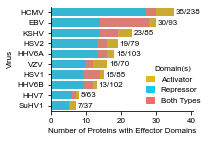

In [22]:
### first run block that plots number of proteins per virus in order to calculate rate
import matplotlib.patches as mpatches
from pandas.api.types import CategoricalDtype

u90 = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/uniref_reviewed_HHV+SuHV.csv')
u90 = u90.rename(columns={'Cluster ID':'UniProt ID'})
dfmap = pd.read_csv('../Supplemental Tables - CSV/uID_protein_virus_mapping_HHV_expanded.csv')
u90 = pd.merge(u90, dfmap, on='UniProt ID', how='left')
u90['Count'] = 1
u90 = u90[['Virus', 'Count']].groupby('Virus', axis=0).sum().reset_index()
u90 = u90[~u90['Virus'].str.contains('CeHV')]
print(u90)

vir2sub = {'HSV1':'alpha', 'HSV2':'alpha', 'VZV':'alpha', 'SuHV1':'alpha',
           'HCMV':'beta', 'HHV6A':'beta', 'HHV6B':'beta', 'HHV7':'beta',
           'EBV':'gamma', 'KSHV':'gamma'}
u90['Subfamily'] = u90['Virus'].map(vir2sub)
u90['Virus'] = u90['Virus'].astype(CategoricalDtype(categories=['SuHV1', 'HSV1', 'HSV2', 'VZV', 'HCMV',
                                                                'HHV6A', 'HHV6B', 'HHV7','EBV', 'KSHV'], ordered=True))
u90 = u90.sort_values(by='Virus')

HHVdom = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_domains_estON-OFF.csv')
HHVdomAct = HHVdom[HHVdom['Effect']=='Activation']
# make dataframe with proteins belonging to multiple virus
HHVdomActDup = HHVdomAct[(HHVdomAct['Virus'])!=(HHVdomAct['Original'])]
HHVdomActDup['Virus'] = HHVdomActDup['Original']
HHVdomActDup = HHVdomActDup.drop_duplicates('Protein ID')
HHVdomActDup['Protein ID'] = HHVdomActDup['Protein ID'] + '-1'
# don't multi-count proteins with multiple domains
HHVdomAct = HHVdomAct.drop_duplicates('Protein ID')
# merge dataframes
HHVdomAct = pd.concat([HHVdomAct, HHVdomActDup])
HHVA_list = list(HHVdomAct['Protein ID'])

HHVdomRep = HHVdom[HHVdom['Effect']=='Repression']
# make dataframe with proteins belonging to multiple virus
HHVdomRepDup = HHVdomRep[(HHVdomRep['Virus'])!=(HHVdomRep['Original'])]
HHVdomRepDup['Virus'] = HHVdomRepDup['Original']
HHVdomRepDup = HHVdomRepDup.drop_duplicates('Protein ID')
HHVdomRepDup['Protein ID'] = HHVdomRepDup['Protein ID'] + '-1'
# don't multi-count proteins with multiple domains
HHVdomRep = HHVdomRep.drop_duplicates('Protein ID')
# merge dataframes
HHVdomRep = pd.concat([HHVdomRep, HHVdomRepDup])
HHVR_list = list(HHVdomRep['Protein ID'])

HHVB_list = [b for b in HHVA_list if b in HHVR_list]
HHVA_list = [a for a in HHVA_list if a not in HHVB_list]
HHVR_list = [r for r in HHVR_list if r not in HHVB_list]

HHVdoms = pd.concat([HHVdomAct, HHVdomRep])
HHVdoms['Count'] = 1
HHVB = HHVdoms[HHVdoms['Protein ID'].str.contains('|'.join(HHVB_list))].drop_duplicates('Protein ID').groupby('Virus').sum().reset_index()
HHVA = HHVdoms[HHVdoms['Protein ID'].str.contains('|'.join(HHVA_list))].drop_duplicates('Protein ID').groupby('Virus').sum().reset_index()
HHVR = HHVdoms[HHVdoms['Protein ID'].str.contains('|'.join(HHVR_list))].drop_duplicates('Protein ID').groupby('Virus').sum().reset_index()

HHVfull = HHVB[['Virus', 'Count']]
# print(HHVfull[HHVfull['Virus']=='SuHV1'])
HHVfull = HHVfull.rename(columns={'Count':'Bifunctional'})
for hhvdf, hhvtype in zip([HHVR, HHVA], ['Repressor', 'Activator']):
    hhvdf = hhvdf[['Virus', 'Count']]
    hhvdf = hhvdf.rename(columns={'Count':hhvtype})
    HHVfull = pd.merge(HHVfull, hhvdf, on='Virus', how='outer').fillna(0)

HHVfull['Bifunctional'] = HHVfull['Repressor'] + HHVfull['Bifunctional']
HHVfull['Activator'] = HHVfull['Activator'] + HHVfull['Bifunctional']
HHVfull = HHVfull.sort_values(by='Activator', ascending=False)
HHVfull = HHVfull[~HHVfull['Virus'].str.contains('CeHV', regex=True)]

totalprots = dict(zip(list(u90['Virus']), list(u90['Count'])))
HHVfull['Activator'] = HHVfull['Activator'].astype(int)
HHVfull['Total'] = HHVfull['Virus'].map(totalprots)
HHVfull['Rate'] = HHVfull['Activator'].astype(str) + '/' + HHVfull['Total'].astype(str)
labels = list(HHVfull['Rate'])
xpos = [x + 0.5 for x in list(HHVfull['Activator'])]
ypos = list(range(len(labels)))

# colors = ['#E3B919', '#1BC6EE', '#CE5F24']
colors = ['#E3B919', '#1BC6EE', '#EA7063']

plt.figure(figsize=(3,2))
barA = sns.barplot(data=HHVfull, x='Activator', y='Virus', color=colors[0])
barB = sns.barplot(data=HHVfull, x='Bifunctional', y='Virus', color=colors[2])
barR = sns.barplot(data=HHVfull, x='Repressor', y='Virus', color=colors[1])

for l, x, y in zip(labels, xpos, ypos):
    plt.annotate(text=l, xy=(x, y), ha='left', va='center')

sns.despine()

A_bar = mpatches.Patch(color=colors[0], label='Activator')
B_bar = mpatches.Patch(color=colors[2], label='Both Types')
R_bar = mpatches.Patch(color=colors[1], label='Repressor')

plt.legend(handles=[A_bar, R_bar, B_bar], loc='lower right', bbox_to_anchor=(1.1, 0),
           frameon=False, title='Domain(s)', handlelength=1)
plt.xlabel('Number of Proteins with Effector Domains')
plt.xlim(0, xpos[0] + 5)
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 2/HHV_domain_virus_distribution_bar_annotated.png', dpi=1200)

### vTR + HHV Overlap

#### Venn diagram featured in 2E

67
147 34 31


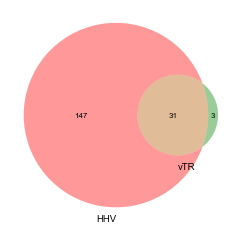

In [24]:
# !{sys.executable} -m pip install matplotlib_venn
from matplotlib_venn import venn2

vTRprot = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/uniprot_vTR-census_wo-BSL4.csv')
vTRList = list(vTRprot['Entry'])

HHVprot = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_full-length-proteins_uID_sequence.csv')
HHVList = list(HHVprot['Cluster ID'])

shared = [i for i in vTRList if i in HHVList]
print(len(shared))
dom_vTR = pd.read_csv('../Supplemental Tables - CSV/vTR-CoV-tiling/vTR_domains_estON-OFF.csv')
dom_HHV = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_domains_estON-OFF.csv')

vA = list(set(list(dom_vTR[dom_vTR['Effect']=='Activation']['Protein ID'])))
hA = list(set(list(dom_HHV[dom_HHV['Effect']=='Activation']['Protein ID'])))
vR = list(set(list(dom_vTR[dom_vTR['Effect']=='Repression']['Protein ID'])))
hR = list(set(list(dom_HHV[dom_HHV['Effect']=='Repression']['Protein ID'])))

dom_vTR2 = vA + vR
dom_vTR2 = list(set([v for v in dom_vTR2 if v in HHVList]))
dom_HHV2 = hA + hR
dom_HHV2 = list(set(dom_HHV2))
dom_vTR_HHV2 = list(set([v for v in dom_vTR2 if v in dom_HHV2]))
# nondom_vTR = list(set([v for v in dom_vTR if v not in dom_HHV]))
print(len(dom_HHV2)-len(dom_vTR_HHV2), len(dom_vTR2), len(dom_vTR_HHV2))

dom_new = [v for v in dom_HHV2 if v not in dom_vTR_HHV2]
dom_new_df = dom_HHV[dom_HHV['Protein ID'].isin(dom_new)].drop_duplicates(subset='Protein ID')
dom_new_df = dom_new_df[['Protein ID', 'Virus', 'Protein', 'Gene', 'Location']]
dom_new_df.to_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_specific_effector_proteins.csv', index=False)

venn2(subsets = (147, 3, 31), set_labels = ('HHV', 'vTR'))
plt.savefig('../Individual Figure Panels/Figure 2/Venn_diagram_of_hit_proteins_vTR-vs-HHV.png', dpi=1200)

### Domain-level Analyses - Strip Plots of Domain Scores

#### Stripplots featured in Fig. 2F&G

In [25]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

from matplotlib.text import Text

alpha = '#9AC42D'
beta = '#63A8DB'
gamma = '#804571'

###############################

dom = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_domains_estON-OFF.csv')

subfamDict = {'SuHV1':'alpha', 'HSV1':'alpha', 'HSV2':'alpha', 'VZV':'alpha', 'HCMV':'beta',
              'HHV6A':'beta', 'HHV6B':'beta', 'HHV7':'beta', 'EBV':'gamma', 'KSHV':'gamma', 'CeHV1':'alpha'}
colorDict = {'alpha':alpha, 'beta':beta, 'gamma':gamma}
dom['Subfamily'] = dom['Virus'].map(subfamDict)
dom['HHV+vTR'] = np.where(dom['Protein ID'].isin(dom_vTR_HHV2), 1, 0)

def plot_domEffects(df, screentype, lower_lim, savename):
    df = df[df['Effect']==screentype].sort_values(by='Max Score', ascending=False)
    famorder = list(df.drop_duplicates(subset=['Subfamily'])['Subfamily'])
    pal = sns.color_palette([colorDict[f] for f in famorder])
    print(famorder)
    
    if screentype == 'Activation':
        plt.figure(figsize=(4.63, 1.26))
        labelname = 'Activation\nlog$_2$(ON:OFF)'
        color = '#D7AC00'
        plt.yticks(ticks=[5, 10], labels=[5,10])
    elif screentype == 'Repression':
        plt.figure(figsize=(4.9,1.4))
        labelname = 'Repression\nlog$_2$(OFF:ON)'
        color = '#23BEDB'
    
    tempdf = df.groupby(by='UniProt Protein Family')['Max Score', 'HHV+vTR'].max().sort_values(by='Max Score', ascending=False).reset_index()
    if len(tempdf) > 40:
        toplot = list(tempdf['UniProt Protein Family'])[:40]
        df = df[df['UniProt Protein Family'].isin(toplot)]
    
    xlabs = list(tempdf['UniProt Protein Family'])
    labcolors = list(tempdf['HHV+vTR'])
    
    sns.stripplot(data=df, x='UniProt Protein Family', y='Max Score', hue='Subfamily', s=2.5, palette=pal)
    plt.xticks(rotation=90)
    lower_y, upper_y = plt.gca().get_ylim()
    plt.ylim(lower_lim, upper_y)
    plt.ylabel(labelname)
    
    if screentype == 'Activation':
        handles, labels = plt.gca().get_legend_handles_labels()
        handles.append(Text(-1, -1, 'abc'))
        labels.append('Shared with vTR')
        print(handles, labels)
        order = [2, 1, 0, 3] # order of genome types when ranking data from strongest to weakest domain
        plt.legend(handles = [handles[i] for i in order], labels = [labels[i] for i in order],
                   frameon=False, loc='upper left', bbox_to_anchor=(1.04,1), title='Subfamily',
                   markerscale=0.3, borderpad=0, handletextpad=0, handlelength=2.2, labelspacing=0.25)
        plt.xlabel('')
    elif screentype == 'Repression':
        plt.legend([], frameon=False)
        plt.xlabel('Viral Protein Family')
        
    labcolDict = {1:'#ab70c1', 0:'k'}
    for xtick, xlab, c in zip(plt.gca().get_xticklabels(), xlabs, labcolors):
        xtick.set_label(xlab)
        xtick.set_color(labcolDict[c])
        
    plt.tight_layout()
    plt.savefig(savename, dpi=1200)
    plt.close()
    print('%s complete' % screentype)

savenameA = '../Individual Figure Panels/Figure 2/HHV_Activation_domains_ranked_protein-label-color.png'
plot_domEffects(dom, 'Activation', cutoffA_HHV, savenameA)

savenameR = '../Individual Figure Panels/Figure 2/HHV_Repression_domains_ranked_protein-label-color.png'
plot_domEffects(dom, 'Repression', cutoffR_HHV, savenameR)


['gamma', 'beta', 'alpha']


<ipython-input-25-1d1ea56b4dcb>:37: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tempdf = df.groupby(by='UniProt Protein Family')['Max Score', 'HHV+vTR'].max().sort_values(by='Max Score', ascending=False).reset_index()


[<matplotlib.collections.PathCollection object at 0x0000023CF64522B0>, <matplotlib.collections.PathCollection object at 0x0000023CF6452640>, <matplotlib.collections.PathCollection object at 0x0000023CF6452A30>, Text(-1, -1, 'abc')] ['gamma', 'beta', 'alpha', 'Shared with vTR']


<ipython-input-25-1d1ea56b4dcb>:57: UserWarning: Legend does not support Text(-1, -1, 'abc') instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles = [handles[i] for i in order], labels = [labels[i] for i in order],


Activation complete
['gamma', 'beta', 'alpha']


<ipython-input-25-1d1ea56b4dcb>:37: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tempdf = df.groupby(by='UniProt Protein Family')['Max Score', 'HHV+vTR'].max().sort_values(by='Max Score', ascending=False).reset_index()


Repression complete


### Biological process GO terms for the 147 new effectors

#### Barplot featured in Fig. 2H

                         BP  Count
1                  Multiple     29
2           DNA replication     18
3               Viral entry     11
4           Gene expression     10
5        Immune suppression     10
6           Virion assembly      7
7                DNA repair      2
8   Modulation of apoptosis      2
9   Protein phosphorylation      2
10              Proteolysis      2
0                     Other      5
0            None annotated     49


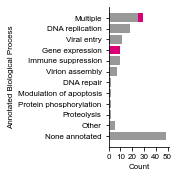

In [61]:
font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)

hgo = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_specific_effector_proteins_GO_info.tsv', sep='\t')
pID = list(hgo['Entry'])
GObp = list(hgo['Gene Ontology (biological process)'])
GOcc = list(hgo['Gene Ontology (cellular component)'])
GOmf = list(hgo['Gene Ontology (molecular function)'])

def extract_GO(ID, GO):
    new_ID = []
    new_GO = []
    new_code = []
    for p, g in zip(ID, GO):
#         print(p, g)
        if type(g) == float:
            new_ID.append(p)
            new_GO.append(g)
            new_code.append(g)
        else:
            g_sub = g.split(';')
            for s in g_sub:
                new_ID.append(p)
                new_GO.append(s.split('[')[0][:-1])
                new_code.append(s.split('[')[1][:-1])
    df = pd.DataFrame({'UniProt ID':new_ID, 'GO':new_GO, 'Code':new_code})
    df['Count'] = 1
    df = df.fillna('-')
    df = df.groupby(by=['GO', 'Code']).sum().reset_index()
    return df

GObp_df = extract_GO(pID, GObp)
GOcc_df = extract_GO(pID, GOcc)
GOmf_df = extract_GO(pID, GOmf)

GObp_df.to_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_specific_effector_proteins_GO_BP_agg.csv', index='False')
GOcc_df.to_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_specific_effector_proteins_GO_CC_agg.csv', index='False')
GOmf_df.to_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_specific_effector_proteins_GO_MF_agg.csv', index='False')

GOBP = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_specific_effector_proteins_GO_info_ANNOTATED.csv').fillna('None annotated')
GOBP['Count'] = 1
GOBP = GOBP.groupby('BP').sum().sort_values(by='Count', ascending=False).reset_index()

tocut = 11
GOBP = pd.concat([GOBP.head(tocut), pd.DataFrame({'BP':'Other', 'Count':[sum(list(GOBP.tail(len(GOBP) - tocut)['Count']))]})])
GOBP = pd.concat([GOBP.tail(len(GOBP) - 1), GOBP.head(1)])
GOBP = GOBP.replace(to_replace=['Regulation of gene expression', 'Suppression of immune response', 'Multifunctional'],
                    value=['Gene expression', 'Immune suppression', 'Multiple'])

fig, ax = plt.subplots(figsize=(2.5, 2.5))

for x, y, bp in zip(list(GOBP['Count']), list(range(len(GOBP['BP'])))[-1::-1], list(GOBP['BP'])):
    if bp == 'Gene expression':
        ax.barh(y, x, color='#D90077')
    elif bp == 'Multiple':
        ax.barh(y, x, color='#D90077') # for stacked bar effect, first plot full count in gene expression color
        ax.barh(y, x-4, color='#999999') # add gray bar on top with height of non-gene expression count (there are 4 gene expression counts)
    else:
        ax.barh(y, x, color='#999999')

print(GOBP)
# sns.barplot(data=GOBP, x='Count', y='BP', color='#999999')
plt.ylabel('Annotated Biological Process')
plt.yticks(ticks=list(range(len(GOBP['BP'])))[-1::-1], labels=list(GOBP['BP']))
plt.xlabel('Count')
plt.xticks(ticks=[0, 10, 20, 30, 40, 50], labels=[0, 10, 20, 30, 40, 50])
sns.despine()
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 2/HHV_specific_effector_proteins_GO_BP_barplot.png', dpi=1200)

### RNA-seq for U84, RL5A, and U8

#### Volcano plots for Fig. 2I-K

In [10]:
from matplotlib.ticker import MultipleLocator

font = {'size':8,
        'family':'Arial'}
matplotlib.rc('font', **font)
print('loaded')

def volcano(df, symbol, savename):
    df['-log10(padj)'] = -np.log10(df['padj'])
    df['-log10(padj)'] = np.where(df['-log10(padj)']==np.inf, 300, df['-log10(padj)'])
    df['-log10(padj)'] = np.where(df['-log10(padj)']>50, 50, df['-log10(padj)'])
    df['Color'] = np.where((df['-log10(padj)']>-np.log10(0.05)) & (df['log2FoldChange']<-1), -1, 0)
    df['Color'] = np.where((df['-log10(padj)']>-np.log10(0.05)) & (df['log2FoldChange']>1), 1, df['Color'])
    
    pal = sns.color_palette(['#00b0c7', '#999999', '#DAA520'])
    plt.figure(figsize=(1.8, 1.5))
    sns.scatterplot(data=df, x='log2FoldChange', y='-log10(padj)', hue='Color', alpha=0.5, linewidth=0, s=5, palette=pal)
    plt.axvline(x=1, ls=':', color='#333333', lw=0.5)
    plt.axvline(x=-1, ls=':', color='#333333', lw=0.5)
    plt.axhline(y=-np.log10(0.05), ls=':', color='#333333', lw=0.5)
    plt.xlim(-10, 10)
    plt.xticks([-9, -6, -3, 0, 3, 6, 9])
    plt.axes().xaxis.set_minor_locator(MultipleLocator(1))
#     matplotlib.axis.xaxis.set_minor_locator(MultipleLocator(1))
    plt.xlabel('log$_2$(Fold Change)')
    plt.ylim(-5, 55)
    plt.ylabel('-log$_{10}$(Adj. p-value)')
    plt.legend('', frameon=False)
    plt.title(symbol + ' vs. negative control', fontsize=8)
    plt.tight_layout()
    sns.despine()
    
    plt.savefig(savename, dpi=1200)
    plt.close()

def GOterms(df, symbol, direction, savename):
    df['Fraction'] = df['Significant']/df['Annotated']
    df['-log10(p)'] = -np.log10(df['result1'])
    plt.figure(figsize=(6,3.5))
    sns.scatterplot(data=df.sort_values(by='Fraction', ascending=False), x='Fraction', y='Term', hue='-log10(p)', size='Significant')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    plt.xlim(0,1)
    plt.xlabel('Fraction of Genes in Set')
    plt.title('%s - GO Terms for %sregulated Genes' % (symbol, direction), fontsize=8)
    plt.tight_layout()
    plt.savefig(savename, dpi=1200)
    plt.close()

print('Functions defined')

loaded
Functions defined


In [11]:
U84deseq = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL457-CL048_dox.csv')
U8deseq = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL456-CL048_dox.csv')
RL5Adeseq = pd.read_csv('../Supplemental Tables - CSV/RNA-seq/DEseq/CL418-CL048_dox.csv')

volcano(U84deseq, 'U84', '../Individual Figure Panels/Figure 2/U84_volcano_replotted_unlabeled.png')
volcano(U8deseq, 'U8', '../Individual Figure Panels/Figure 2/U8_volcano_replotted_unlabeled.png')
volcano(RL5Adeseq, 'RL5A', '../Individual Figure Panels/Figure 2/RL5A_volcano_replotted_unlabeled.png')


<ipython-input-10-9db2822f935a>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_minor_locator(MultipleLocator(1))
<ipython-input-10-9db2822f935a>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_minor_locator(MultipleLocator(1))
<ipython-input-10-9db2822f935a>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier inst

#### Small tiling plots for Fig. 2I-K

In [28]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date updated: 5/10/2022

# NOTE: these functions use a few global variables, including:
# - hits thresholds for activation and repression screens
# - minimum and maximum screen scores for non-controls to set axis limits
# - dictionary that maps UniProt IDs to protein and virus

# make sure to run the above cells to get these global variables

import mpl_axes_aligner

# this function gets domain start and stop coordinates, as well as max tile score
def domainLimits(temp_df):
    span_starts = []
    span_ends = []
    scores = []
    temp_df_hits = temp_df[temp_df['Hit']==1]
    indices = range(0, len(temp_df_hits))
    temp_df_hits.insert(0, 'index', indices)
    temp_df_hits.set_index('index', inplace=True)
    
    if len(temp_df_hits) == 0:
        return span_starts, span_ends, scores
    temp_start = np.nan
    temp_scores = []
    # create range for all tiles excluding the last tile
    for i in range(0, len(temp_df_hits)):
        # if tile is last one
        if i == (len(temp_df_hits) - 1):
            # if temporary start of domain has been defined
            if ~np.isnan(temp_start):
                span_starts.append(temp_start)
                span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                scores.append(max(temp_scores))
            # if tile is the only tile (first and last)
            elif int(temp_df_hits.loc[i, 'Tile ID'].split('_')[-1]) == 1:
                span_starts.append(temp_df_hits.loc[i, 'Tile Start'])
                span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                scores.append(temp_df_hits.loc[i, 'Avg'])
        # if tile is not last one
        else:
            # if not consecutive
            if (int(temp_df_hits.loc[i, 'Tile ID'].split('_')[-1]) + 1) != (int(temp_df_hits.loc[i+1, 'Tile ID'].split('_')[-1])):
                # if a temporary start of the domain has been defined, then store that start and the end of this tile
                if ~np.isnan(temp_start):
                    span_starts.append(temp_start)
                    span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                    scores.append(max(temp_scores))
                    # reset temporary start to nan
                    temp_start = np.nan
                    temp_scores = []
                # if the tile is at the N-terminus, then store the start/stop of the domain
                elif int(temp_df_hits.loc[i, 'Tile ID'].split('_')[-1]) == 1:
                    span_starts.append(temp_df_hits.loc[i, 'Tile Start'])
                    span_ends.append(temp_df_hits.loc[i, 'Tile End'])
                    scores.append(temp_df_hits.loc[i, 'Avg'])
            # if consecutive
            else:
                # if start of domain is not yet defined
                if np.isnan(temp_start):
                    temp_start = temp_df_hits.loc[i, 'Tile Start']
                    temp_scores.append(temp_df_hits.loc[i, 'Avg'])
                # if tile is in the middle of a domain
                else:
                    temp_scores.append(temp_df_hits.loc[i, 'Avg'])
                    continue
                
    return span_starts, span_ends, scores

###############################
        
# this function makes tiling plots
def plotDomain_small(gene, temp_df, protDF, domainDict, indivDir_path, save_root):
    # subset for activation
    temp_dfA = temp_df[temp_df['Screen']=='Activation']
    temp_dfA = temp_dfA.drop_duplicates(subset='Tile ID')
    temp_IDsA = list(temp_dfA['Oligo ID'])
    temp_dfA.set_index('Oligo ID', inplace=True)
    
    # get activation points and error
    xA = [(1 + (temp_dfA.loc[ID]['Tile Start'] + temp_dfA.loc[ID]['Tile End'] - 1)/2) for ID in temp_IDsA]
    xerrA = [(temp_dfA.loc[ID]['Tile End'] - temp_dfA.loc[ID]['Tile Start'] + 1)/2 for ID in temp_IDsA]
    yA = [temp_dfA.loc[ID]['Avg'] for ID in temp_IDsA]
    yerrA = list(temp_dfA['Standard Error'])
    
    # get activation domain info
    domain_startsA, domain_endsA, scoresA = domainLimits(temp_dfA)
    print('Activation domain starts/stops/scores:', domain_startsA, domain_endsA, scoresA)

    # subset for repression
    temp_dfR = temp_df[temp_df['Screen']=='Repression']
    temp_dfR = temp_dfR.drop_duplicates(subset='Tile ID')
    temp_IDsR = list(temp_dfR['Oligo ID'])
    temp_dfR.set_index('Oligo ID', inplace=True)
    
    # get repression points and error
    xR = [(1 + (temp_dfR.loc[ID]['Tile Start'] + temp_dfR.loc[ID]['Tile End'] - 1)/2) for ID in temp_IDsR]
    xerrR = [(temp_dfR.loc[ID]['Tile End'] - temp_dfR.loc[ID]['Tile Start'] + 1)/2 for ID in temp_IDsR]
    yR = [temp_dfR.loc[ID]['Avg'] for ID in temp_IDsR]
    yerrR = list(temp_dfR['Standard Error'])
    
    # get repression domain info
    domain_startsR, domain_endsR, scoresR = domainLimits(temp_dfR)
    print('Repression domain starts/stops/scores:', domain_startsR, domain_endsR, scoresR)

    # create axis objects and plot tile centers vs log2(ON:OFF) scores
    fig, ax = plt.subplots(figsize=(1.2,0.8))
    ax2 = ax.twinx()
    colors = ['#23BEDB', '#D7AC00', '#DB3982']
    markersize = 4
    
    # the following stores extended domain and strongest tile info in domainDict
    # it also draws horizontal spans that highlight the strongest tile in each domain
    # activators
    if len(domain_startsA) != 0:
        for s, e, c in zip(domain_startsA, domain_endsA, scoresA):
            domA = temp_dfA[(temp_dfA['Tile Start']>=s) & (temp_dfA['Tile End']<=e)]
            startindex = int(s)
            endindex = int(e)
            domseq = protDF.loc[gene, 'Representative Sequence'][(startindex - 1):endindex]
            max_avg = max(list(domA['Avg']))
            max_coords = [domA[domA['Avg']==max_avg]['Tile Start'][0], domA[domA['Avg']==max_avg]['Tile End'][0]]
            max_seq = domA[domA['Avg']==max_avg]['Tile Sequence'][0]
            
            to_append = [gene, startindex, endindex, len(domseq), domseq,
                         max_coords[0], max_coords[1], max_seq, c, 'Activation']
            for k, v in zip(domainDict.keys(), to_append):
                domainDict[k].append(v)
            
            ax.axvspan(xmin=max_coords[0], xmax=max_coords[1], color='#f5dc79', alpha=0.4, lw=0.8, zorder=-200)
    
    # repressors
    if len(domain_startsR) != 0:
        for s, e, c in zip(domain_startsR, domain_endsR, scoresR):
            domR = temp_dfR[(temp_dfR['Tile Start']>=s) & (temp_dfR['Tile End']<=e)]
            startindex = int(s)
            endindex = int(e)
            domseq = protDF.loc[gene, 'Representative Sequence'][(startindex - 1):endindex]
            max_avg = max(list(domR['Avg']))
            max_coords = [domR[domR['Avg']==max_avg]['Tile Start'][0], domR[domR['Avg']==max_avg]['Tile End'][0]]
            max_seq = domR[domR['Avg']==max_avg]['Tile Sequence'][0]
            
            to_append = [gene, startindex, endindex, len(domseq), domseq,
                         max_coords[0], max_coords[1], max_seq, c, 'Repression']
            for k, v in zip(domainDict.keys(), to_append):
                domainDict[k].append(v)
            
            ax.axvspan(xmin=max_coords[0], xmax=max_coords[1], color='#bbdaee', alpha=0.4, lw=0.8, zorder=-150)
     
    # plot tiles, with activators on y-axis 1 and repressors on y-axis 2
    ax.scatter(xA, yA, c=colors[1], zorder=-100, s=markersize)
    for xi, yi, exi, eyi in zip(xA, yA, xerrA, yerrA):
        ax.errorbar(xi, yi, xerr=exi, yerr=eyi, color=colors[1], zorder=-100, lw=0.8)
    
    ax2.scatter(xR, yR, c=colors[0], zorder=-50, s=markersize)
    for xi, yi, exi, eyi in zip(xR, yR, xerrR, yerrR):
        ax2.errorbar(xi, yi, xerr=exi, yerr=eyi, color=colors[0], zorder=-50, lw=0.8)
    
    uID = gene.split('(')[-1]
    
    titleDict = {'P52534':'HHV7 U84', 'F5HF23':'HCMV RL5A', 'P52523':'HHV7 U8'}
    ax.set_title(titleDict[uID], fontsize=8, pad=0)
    colorsTitle = ['#01a4c2', '#c29d09']
    ax.set_yticks([])
    ax2.set_yticks([])
    ax.set_ylabel('Act.', color=colorsTitle[1], labelpad=1)
    ax2.set_ylabel('Repr.', color=colorsTitle[0], rotation=270, labelpad=8)
    ax2.axhspan(ymin=minScoreA - 0.5, ymax=cutoffR_HHV, color='#FFFFFF', alpha=0.6, zorder=-15)
    ax2.axhline(y=cutoffR_HHV, linestyle='--', color='#666666', lw=1)
    ax.set_ylim(minScoreA - 0.5, maxScoreA + 0.5)
    ax2.set_ylim(minScoreR - 0.5, maxScoreR + 0.5)
    mpl_axes_aligner.align.yaxes(ax, cutoffA_HHV, ax2, cutoffR_HHV, 0.5)

    plt.tight_layout()
    
    # save figure and close current plot
    fig_path = os.path.join(indivDir_path, gene_uID_list_dict2[gene] + save_root)
    # do this because you cannot save files with '|' in the name
    fig_path = fig_path.replace('|', '-')
    fig.savefig(fig_path, dpi=1200)
    plt.close()
    
    return domainDict

###############################

# this function batch produces tiling plots while simultaneously storing domain info
def extractDomains(df, protDF, lib_fullName, indivDir_path, save_root):
    if 'herpesvirus' not in lib_fullName:
        df = df[df['Type']==lib_fullName]
    else:
        df = df[(df['Library'].str.contains('herpesvirus')) & (~df['Type'].str.contains('control'))]
    
    # get hits and edit to avoid regex characters
    tileHits = list(df[df['Hit'] == 1]['Oligo ID'])
    geneHits = []
    for hit in tileHits:
        if '|' in hit:
            geneHits.append('_'.join(hit.split('_')[1:3]))
        else:
            geneHits.append(hit.split('_')[1])

    geneHits = set(geneHits)
    geneHitsLen = str(len(geneHits))
    
    # find domains and construct data frame with domain info
    domainDict = {'Protein ID':[],
                  'Extended Start':[],
                  'Extended End':[],
                  'Extended Length':[],
                  'Extended Sequence':[],
                  'Max Start':[],
                  'Max End':[],
                  'Max Sequence':[],
                  'Max Score':[],
                  'Effect':[]}
    incr = 0
    for gene in geneHits:
        incr += 1
        # make temporary dataframe for each gene
        # '|' character is read as an 'or' by regex, so don't include when searching
        if '|' in gene:
            genesearch = '.'.join(gene.split('|'))
        else:
            genesearch = gene
        temp_df = df[df['Oligo ID'].str.contains(genesearch)]
        temp_df = temp_df.sort_values(by='Oligo ID')
        
        # make a plot with enrichment scores for each gene containing hit tiles
        print('Protein %s of %s: plotting log2(ON:OFF) for %s' % (str(incr), geneHitsLen, gene))
        domainDict = plotDomain_small(gene, temp_df, protDF, domainDict, indivDir_path, save_root)

    finalDF = pd.DataFrame(domainDict)
    print('Finished')
    
    return finalDF

print('Domain calling/plotting functions defined')

Domain calling/plotting functions defined


In [29]:
# the following creates dictionaries to map UniProt ID to protein and virus names
# this is specifically to produce tiling plot titles and save names
uID_to_gene_df = pd.read_csv('../Supplemental Tables - CSV/uID_protein_virus_mapping_HHV_expanded.csv')
uID_to_gene_df = uID_to_gene_df.rename(columns={'UniProt ID':'Protein ID'})
uID_list = list(uID_to_gene_df['Protein ID'])
uID_to_gene_df['Virus Protein (ProteinID)'] = uID_to_gene_df['Virus'] + ' ' + uID_to_gene_df['Protein'] + ' (' + uID_to_gene_df['Protein ID'] + ')'
uID_to_gene_df['Protein_Virus_ProteinID'] = uID_to_gene_df['Protein'] + '_' + uID_to_gene_df['Virus'] + '_' + uID_to_gene_df['Protein ID']
gene_uID_list1 = list(uID_to_gene_df['Virus Protein (ProteinID)'])
gene_uID_list_dict1 = dict(zip(uID_list, gene_uID_list1))
gene_uID_list2 = list(uID_to_gene_df['Protein_Virus_ProteinID'])
gene_uID_list_dict2 = dict(zip(uID_list, gene_uID_list2))

###############################

df = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_ActivD2-ReprD5_detailed.csv')
indivDir_path = '../Individual Figure Panels/Figure 2'
save_root = '_tileScores_EBNA.png'
HHVprot = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_full-length-proteins_uID_sequence.csv')
HHVprot = HHVprot.rename(columns={'Cluster ID':'Entry'})
HHVprot = HHVprot[['Entry', 'Representative Sequence']]
HHVprot = HHVprot.set_index('Entry')

if os.path.isdir(indivDir_path) == False:
    print('Making directory called %s to store plots' % indivDir_path)
    os.mkdir(indivDir_path)

# compute minimum and maximum log2(ON:OFF) for plots
cutoffA_HHV = 1.0846347878236864
cutoffR_HHV = 0.6987727639587654
limsA_HHV = (-9.044003705, 11.45554289)
limsR_HHV = (-3.76771998, 7.7418403210000015)
minScoreA = limsA_HHV[0]
maxScoreA = limsA_HHV[1]
minScoreR = limsR_HHV[0]
maxScoreR = limsR_HHV[1]

plotlist = ['P52534', 'F5HF23', 'P52523']
df = df[(df['Protein ID'].isin(plotlist))]
HHVprot = HHVprot[HHVprot.index.isin(plotlist)] # EBNA2 type 1 and type 2 UniProt IDs

# extract domains and make tiling plots
domDF_HHV = extractDomains(df, HHVprot, 'herpesvirus', indivDir_path, save_root)
domDF_HHV = pd.merge(domDF_HHV, uID_to_gene_df, on='Protein ID', how='left')
domDF_HHV = domDF_HHV.drop_duplicates(subset=['Protein ID', 'Max Score', 'Effect'])


Protein 1 of 3: plotting log2(ON:OFF) for P52534
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [11.0] [150.0] [4.900162611]
Protein 2 of 3: plotting log2(ON:OFF) for F5HF23
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [1.0] [95.0] [2.821301289]
Protein 3 of 3: plotting log2(ON:OFF) for P52523
Activation domain starts/stops/scores: [] [] []
Repression domain starts/stops/scores: [51.0] [160.0] [4.288637273]
Finished
